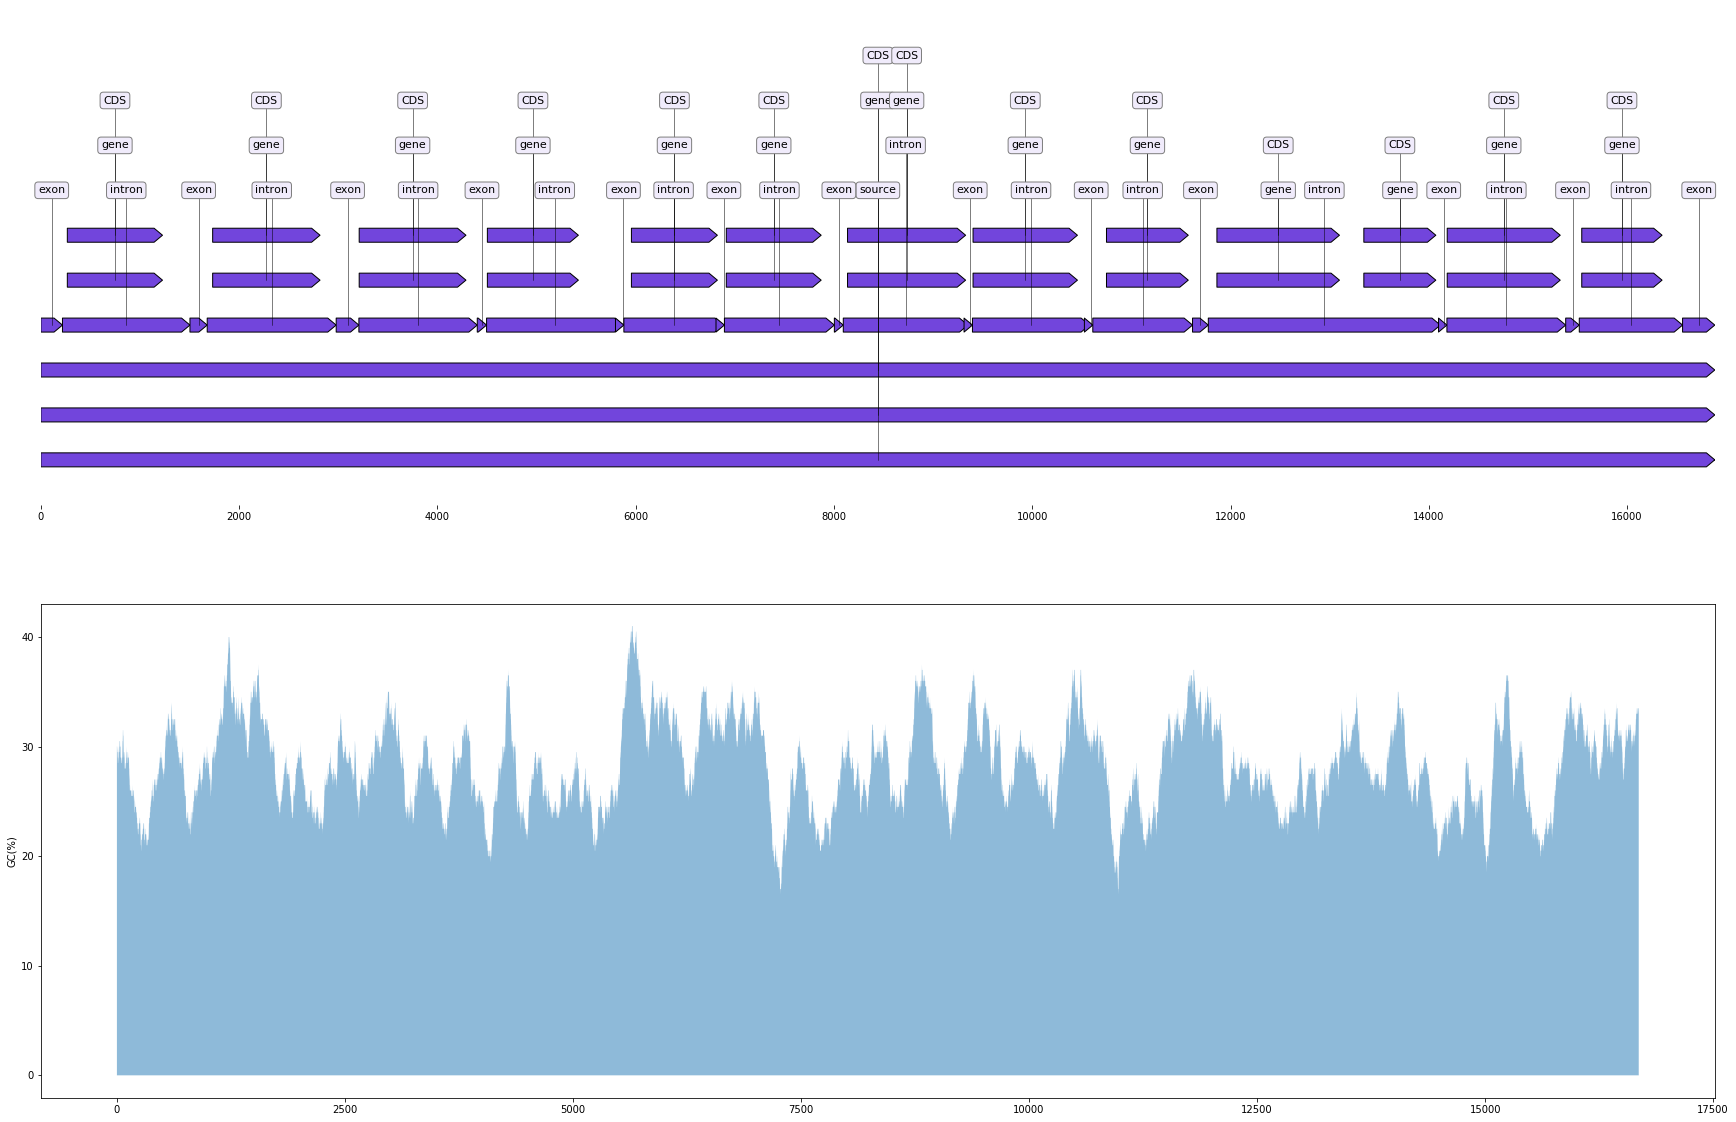

In [3]:
# only for short seqs
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20), sharex=False)

# Parse the genbank file, plot annotations
record = SeqIO.read("/home/pavel/Desktop/ORF_SMTB/ORF_finder/sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
#ax, levels = graphic_record.plot()
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=200, ax=ax2)

# Resize the figure
fig.savefig("with_plot.png")
#Image(filename='with_plot.png') 

Теперь подтянем разметку из .gb файла.

In [ ]:
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord

features = []
for i,j,k,q in zip(sort_final_table_GC_cleaned["Left_border"], sort_final_table_GC_cleaned["Right_border"], sort_final_table_GC_cleaned["Srtand"], sort_final_table_GC_cleaned["Features"]):
    print(i,j,k,q)
    if k == "+":
        features.append(GraphicFeature(start=i, end=j, strand="+1", color='#ffcccc', label=q))
    if k == "-":
        #print(len(sequence))
        features.append(GraphicFeature(start=i, end=j, strand="-1", color='#cffccc', label=q))

#features

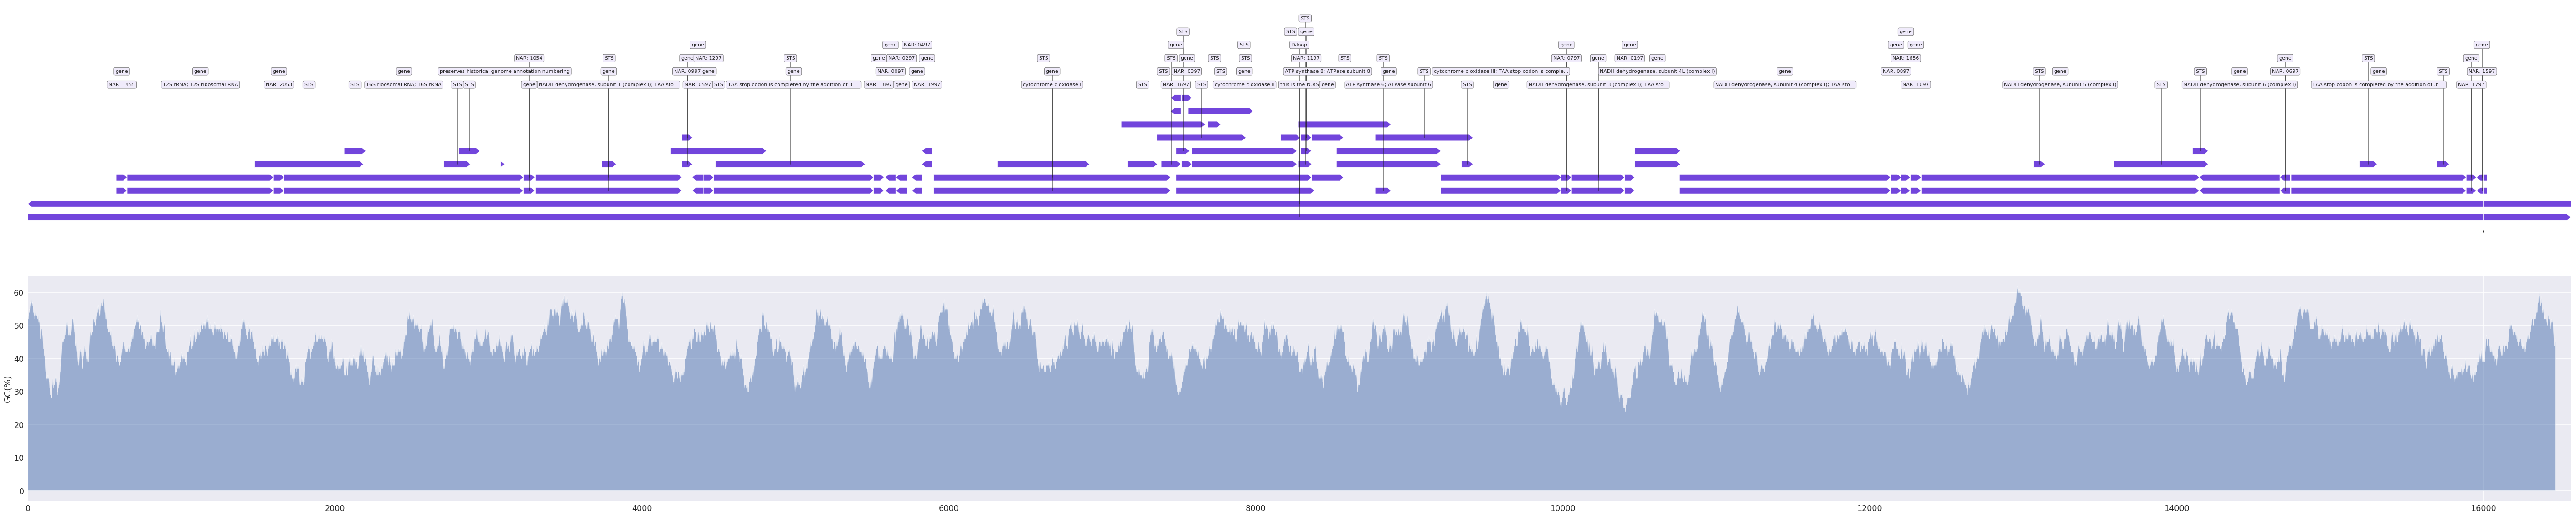

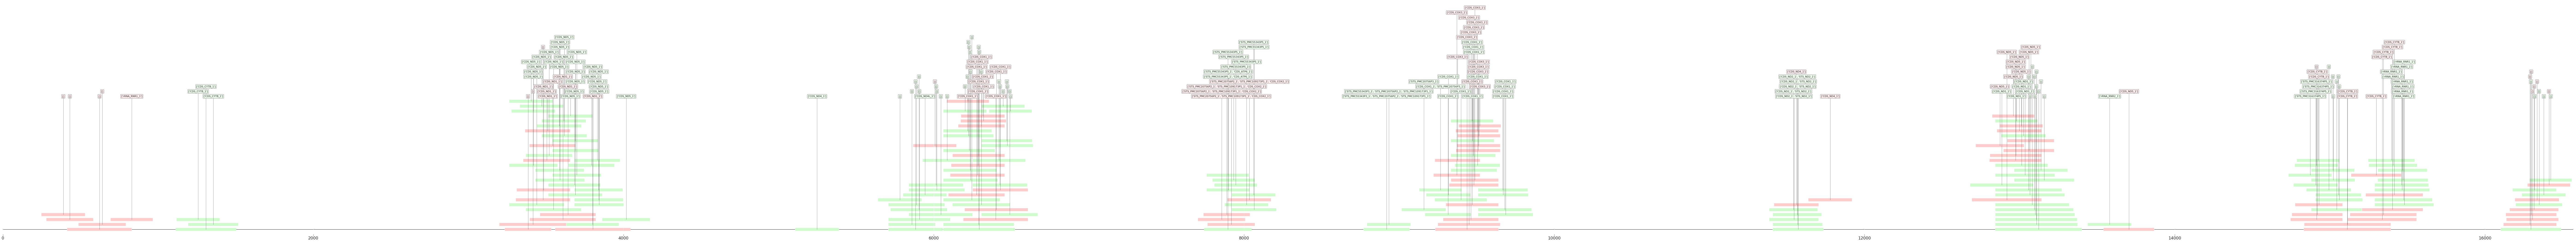

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 20), sharex=True)

# Parse the genbank file, plot annotations
record = SeqIO.read(root + "/sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=100, ax=ax2)

my_record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
ax, _ = my_record.plot(figure_width=200)


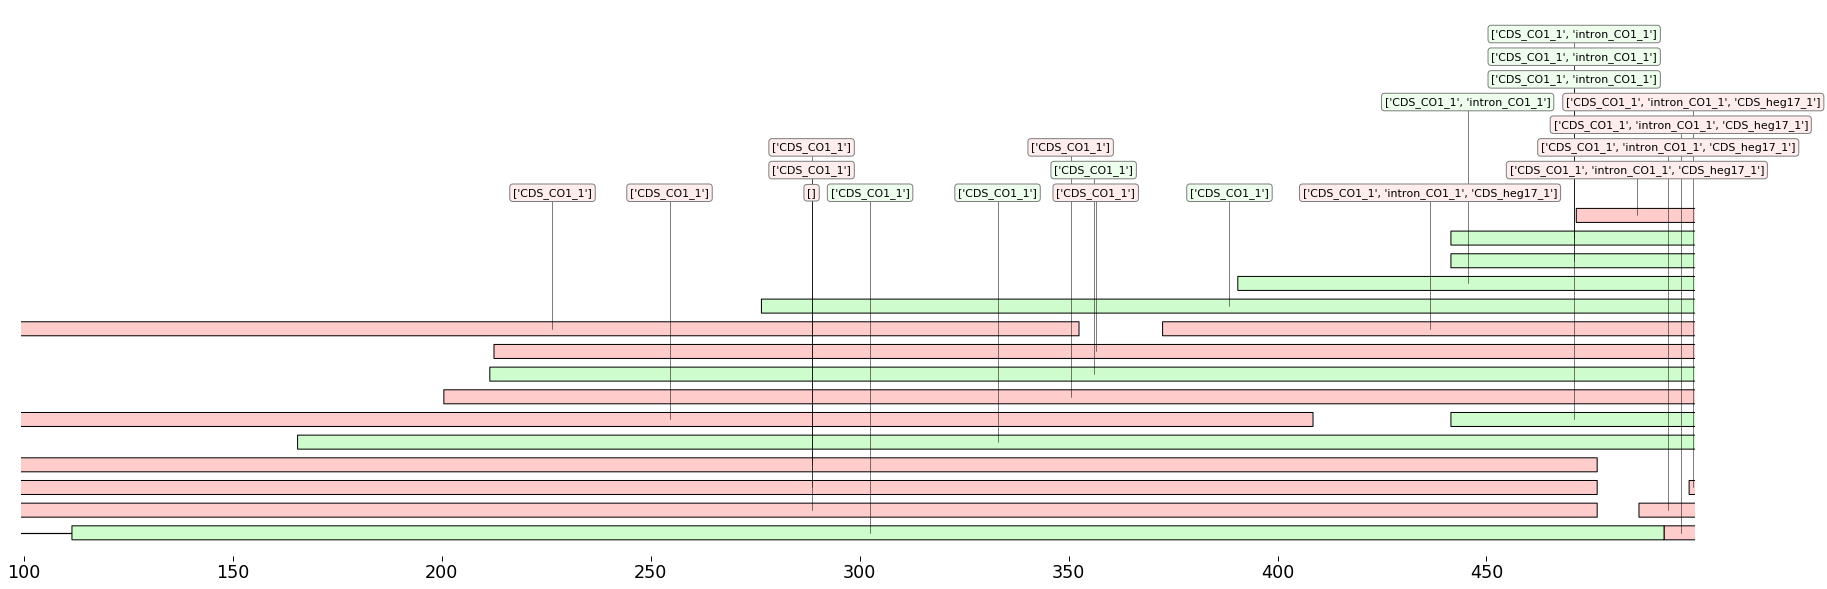

In [121]:
record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
cropped_record = record.crop((100, 500))
ax, _ = cropped_record.plot(figure_width=30)

In [6]:
import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import statistics
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import Entrez
from Bio import SeqIO
Entrez.email= "pavel-kravchenk0@yandex.ru"
from Bio.SeqUtils import GC
from time import clock
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord
from dna_features_viewer import BiopythonTranslator
import subprocess
import random
from random import randrange 
import argparse
from itertools import groupby
import itertools
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, Gapped
from Bio import Phylo
from Bio.Align.Applications import ClustalwCommandline
from sys import argv
from Bio import AlignIO
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from scipy import stats
from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
from skbio import DNA, TabularMSA
import skbio.io
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Data import CodonTable
from fuzzywuzzy import fuzz
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.codonalign.codonseq import _get_codon_list, CodonSeq, cal_dn_ds
from Bio.codonalign.codonalphabet import (default_codon_table, default_codon_alphabet)
from statistics import mean 

In [39]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr
# попробуем сделать все более правильно, так как митохондрии и бактерии имеют разные генетические коды
# сделал подтягивание разметки
# и поиск по бласту(почти всегда работает)
# есть отсечка по нуклеотидным последовательностям, но на больших данных долго считается
# добавил визуализацию
# есть разные характеристики пептида


root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    file_gb = "/home/pavel/Desktop/ORF_SMTB/Sequences/sequence.gb" # str(input("Type the name of gb file "))
except IOError:
    print ("Wrong file name!")

    
minimal_len_prot = 1 # int(input("Type the minimal protein length "))
maximal_len_prot = 200 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4
genetic_code_table_id = 2
stem_threshold = 2

code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score



def ProteinAnalysis_func(protein):
    try:
        X = ProteinAnalysis(protein)
        molecular_weight = X.molecular_weight()
        aromaticity = X.aromaticity()
        instability_index = X.instability_index()
        isoelectric_point = X.isoelectric_point()
        gravy = X.gravy()
        return round(molecular_weight, round_param), round(aromaticity, round_param), round(instability_index, round_param), round(isoelectric_point, round_param), round(gravy, round_param)
    except ValueError:
        return None, None, None, None, None

def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
   
    
def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    local_file = open("blast_" + record_id + ".fasta", 'w')

    counter = 1
    for x in output:
        print(x)
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
        print("Progress is {:2.1%}".format(list(output.keys()).index(x)/len(list(output.keys())), end="\r"))
        
    local_file.close()
    print("Finished genbank processing.")
    


def orf_finder(sequence, frame): # модуль для поиска ORFs
    #stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    #start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    standard_table = CodonTable.unambiguous_dna_by_id[genetic_code_table_id]
    
    stop_codons = standard_table.stop_codons  # стоп кодоны
    start_codon = standard_table.start_codons # старт кодоны (есть дополнительные старт кодоны - )
    #print("stop_codons used ---", stop_codons)
    #print("start_codon used ---", start_codon)
    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
            #print("codon in start_codon")
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()
            #print("codon in stop_codons")
            
    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if minimal_len_prot_3 < delta and maximal_len_prot_3 > delta:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector

def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

    
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])
    
    
def reverseComplement(s):
    basepairs = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    return ''.join(basepairs[b] for b in s[::-1])

def longestStem(s, stem_threshold):
    n = len(s)
    k = int(n/2) #length of longest possible stem
    candidate = ''
    i = 1
    start1 = None
    start2 = None
    
    while i <= k and len(candidate) == i - 1:
        for j in range(n-2*i+1):
            t = s[j:i+j]
            if reverseComplement(t) in s[i+j:]:
                #print(s.find(reverseComplement(t)), s.find(s[i+j:]))
                if s[i+j:].find(reverseComplement(t)) - j > stem_threshold:
                    candidate = t
                    start1 = j
                    start2 = s[i+j:].find(reverseComplement(t))
                    break
        i +=1
    return candidate, start1, start2


    
start = clock()
record = SeqIO.read(file_gb, "genbank")
features_list = []
c = 0
for feature in record.features:
    if feature.type != "gene":
        if c == 2:
            #print(feature.qualifiers, str(feature.qualifiers).split("'"))
            #print(str(feature.qualifiers).split("'"))
            features_list.append([int(feature.location.start), int(feature.location.end), feature.strand, feature.type, str(feature.qualifiers).split("'")[3]])
        else:
            c +=1
#print(features_list)        


sequence = str(record.seq)
name = record.id
print("Seq name is ", name)
print("Seq length is ", len(sequence))
   
basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
if not os.path.exists(basicdir): # если нет basicdir, то создаем
    os.makedirs(basicdir)
os.chdir(basicdir) # заходим в неё
# теперь работаем и сохраняем только в ней
   
#complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
#sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

# можно с помощью функции
#print(sequence)
sequence = Seq(sequence, generic_dna)
sequence_rev = str(sequence.reverse_complement())

sequence = str(sequence)

print("GC%", getGC(sequence))
print("")
    
orf_dict = {}
for i in range(3):  # перебираем каждую из рамок на прямой цепи
    print("Iteration", i)
    frame = i
    orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
    orf_dict[i] = orfs

for j in range(3): # и на обратной
    print("Iteration", -j)
    frame_rev = j
    orfs_rev = orf_finder(sequence_rev, frame_rev)
    orf_dict[j + 3] = orfs_rev

# получили словари с ORFs по рамкам
out_protein_orf_name = "out_protein_orf_" + str(name) + ".csv"
with open(out_protein_orf_name, "w") as out_file:
    out_file.write("Nuc_seq" + 
                   "\t" + "Amino_seq" + 
                   "\t" + "SD_seq" + 
                   "\t" + "SD_score" + 
                   "\t" + "Srtand" + 
                   "\t" + "Frame" + 
                   "\t" + "Left_border" + 
                   "\t" + "Right_border" + 
                   "\t" + "Ama_len" + 
                   "\t" + "GC%" + 
                   "\t" + "GC_fold_change" + 
                   "\t" + "ScoreTr" + 
                   "\t" + "Features" + 
                   "\t" + "Molecular_weight" + 
                   "\t" + "Aromaticity" + 
                   "\t" + "Instability_index" + 
                   "\t" + "Isoelectric_point" + 
                   "\t" + "Gravy" + 
                   "\t" + "Stem_loop_seq" +
                   "\t" + "Stem_loop_found_seq" +
                   "\t" + "Stem_loop_position" +
                   "\n")
    
    for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
        print("Current frame is ",i)
        bin_len_list = []
        prot_calc = 0 # заводим счетчики для полипептидов          
            
        if int(i) <= 2:
            #print(sequence)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)

        if int(i) > 2:
            #print(sequence_rev)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)

        for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
            prot_calc += 1
            if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=genetic_code_table_id, to_stop=False))   
                if "*" in line:
                    break
                bin_len_list = bin_len_list + [len(line)]
                
                SD_seq = sequence[left_border - 20:left_border]
                if len(SD_seq) == 20:
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = None
                                
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, 
                                         code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
                molecular_weight, aromaticity, instability_index, isoelectric_point, gravy = ProteinAnalysis_func(line)
                
                
                Stem_loop_found_seq, Stem_loop_start, Stem_loop_end = longestStem(sequence[left_border - 20:left_border + 20], stem_threshold)
                
                out_file.write(subseq + 
                               "\t" + line + 
                               "\t" + SD_seq + 
                               "\t" + str(SD_score) + 
                               "\t" + "+" + 
                               "\t" + str(i) + 
                               "\t" + str(left_border) + 
                               "\t" + str(right_border) + 
                               "\t" + str(int((right_border - left_border)/3)) + 
                               "\t" + str(getGC(subseq)) + 
                               "\t" + str(getGC(subseq)/getGC(sequence)) + 
                               "\t" + str(scoreTr_result) + 
                               "\t" + str(features_for_orfs) + 
                               "\t" + str(molecular_weight) + 
                               "\t" + str(aromaticity) + 
                               "\t" + str(instability_index) + 
                               "\t" + str(isoelectric_point) + 
                               "\t" + str(gravy) + 
                               "\t" + str(sequence[left_border - 20:left_border + 20]) +
                               "\t" + str(Stem_loop_found_seq) +
                               "\t" + str([Stem_loop_start, Stem_loop_end]) +
                               "\n")
            else:
                pass
             
            
            ###############################
            if int(i) > 2 and len(orf_dict[i][j]) == 2:
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence_rev[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=genetic_code_table_id, to_stop=False))   
                if "*" in line:
                    break
                #print(line)
                bin_len_list = bin_len_list + [len(line)]
                SD_seq = sequence_rev[left_border - 20:left_border]
                #print(len(SD_seq))
                if len(SD_seq) == 20:
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = None
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
   
                left_border = len(sequence) - int(orf_dict[i][j][1]) - 1
                right_border = len(sequence) - int(orf_dict[i][j][0]) - 1
        
                molecular_weight, aromaticity, instability_index, isoelectric_point, gravy = ProteinAnalysis_func(line)
                
                                
                Stem_loop_found_seq, Stem_loop_start, Stem_loop_end = longestStem(sequence_rev[left_border - 20:left_border + 20], stem_threshold)

                out_file.write(subseq + 
                               "\t" + line + 
                               "\t" + SD_seq + 
                               "\t" + str(SD_score) + 
                               "\t" + "-" + 
                               "\t" + str(i) + 
                               "\t" + str(left_border) + 
                               "\t" + str(right_border) + 
                               "\t" + str(int((right_border - left_border)/3)) + 
                               "\t" + str(getGC(subseq)) + 
                               "\t" + str(getGC(subseq)/getGC(sequence_rev)) + 
                               "\t" + str(scoreTr_result) + 
                               "\t" + str(features_for_orfs) + 
                               "\t" + str(molecular_weight) + 
                               "\t" + str(aromaticity) + 
                               "\t" + str(instability_index) + 
                               "\t" + str(isoelectric_point) + 
                               "\t" + str(gravy) +
                               "\t" + str(sequence_rev[left_border - 20:left_border + 20]) +
                               "\t" + str(Stem_loop_found_seq) +
                               "\t" + str([Stem_loop_start, Stem_loop_end]) +
                               "\n")
            else:
                pass
             
                 

        print("It has been found " + str(prot_calc) + " proteins")
        print("")
                
        try:
            print("Protein length by bins:")
            print("Bin size =", bin_size)
            l = numpy.array(bin_len_list)
            bins = numpy.arange(0, max(l), bin_size)
            print("Bin" + "\t" + "Score")
            for s in range(1,len(bins)):
                print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
            print("")
    
            if hist == "y":
                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(16, 10)
                sns.set_context("paper", font_scale=2)
                
                plt.hist(l, bin_size, alpha = 0.8)
                plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                plt.xlabel('Length')
                plt.ylabel('Number of proteins')
                        
                plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                #plt.show()
                plt.gcf().clear()
            print("")
        except ValueError:
            continue

  
final_table = pd.read_csv(basicdir + "/out_protein_orf_" + str(name) + ".csv", sep='\t')
final_table['index'] = range(0, len(final_table))

'''
GC_list = list(final_table["GC_fold_change"])
#print(GC_list)

stdev_GC_list = statistics.stdev(GC_list)
mean_GC_list = statistics.mean(GC_list)
#print(stdev_GC_list, mean_GC_list)

final_table_GC_cleaned = final_table[list(final_table["GC_fold_change"] >= mean_GC_list + stdev_GC_list) or list(final_table["GC_fold_change"] <= mean_GC_list - stdev_GC_list)]
final_table_GC_cleaned[final_table_GC_cleaned["SD_score"] != 0.0]
final_table_GC_cleaned

sort_final_table_GC_cleaned = final_table_GC_cleaned.sort_values('SD_score',ascending=False)

final_table = sort_final_table_GC_cleaned
            
features = []

for i,j,k,q in zip(final_table["Left_border"], final_table["Right_border"], final_table["Srtand"], final_table["Features"]):
    #print(i,j,k,q)
    if k == "+":
        features.append(GraphicFeature(start=i, end=j, strand="+1", color='#ffcccc', label=q))
    if k == "-":
        #print(len(sequence))
        features.append(GraphicFeature(start=i, end=j, strand="-1", color='#cffccc', label=q))

#features


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 20), sharex=True)

# Parse the genbank file, plot annotations
file_gb
graphic_record = BiopythonTranslator().translate_record(file_gb)
graphic_record.plot(ax=ax1, with_ruler=True)

plot_local_gc_content(record, window_size=100, ax=ax2)

my_record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
ax, _ = my_record.plot(figure_width=50)


print("Done")  # the end
'''

Start script
Seq name is  NC_012920.1
Seq length is  16569
GC% 0.4436

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 36 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	17
2	6
3	5
4	3
5	1
6	1


Current frame is  1
It has been found 16 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	7


Current frame is  2
It has been found 31 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	23


Current frame is  3
It has been found 2 proteins

Protein length by bins:
Bin size = 20
Bin	Score


Current frame is  4
It has been found 40 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	22
2	15


Current frame is  5
It has been found 1 proteins

Protein length by bins:
Bin size = 20


'\nGC_list = list(final_table["GC_fold_change"])\n#print(GC_list)\n\nstdev_GC_list = statistics.stdev(GC_list)\nmean_GC_list = statistics.mean(GC_list)\n#print(stdev_GC_list, mean_GC_list)\n\nfinal_table_GC_cleaned = final_table[list(final_table["GC_fold_change"] >= mean_GC_list + stdev_GC_list) or list(final_table["GC_fold_change"] <= mean_GC_list - stdev_GC_list)]\nfinal_table_GC_cleaned[final_table_GC_cleaned["SD_score"] != 0.0]\nfinal_table_GC_cleaned\n\nsort_final_table_GC_cleaned = final_table_GC_cleaned.sort_values(\'SD_score\',ascending=False)\n\nfinal_table = sort_final_table_GC_cleaned\n            \nfeatures = []\n\nfor i,j,k,q in zip(final_table["Left_border"], final_table["Right_border"], final_table["Srtand"], final_table["Features"]):\n    #print(i,j,k,q)\n    if k == "+":\n        features.append(GraphicFeature(start=i, end=j, strand="+1", color=\'#ffcccc\', label=q))\n    if k == "-":\n        #print(len(sequence))\n        features.append(GraphicFeature(start=i, end=j

<Figure size 1152x720 with 0 Axes>

In [40]:
final_table

,Nuc_seq,Amino_seq,SD_seq,SD_score,Srtand,Frame,Left_border,Right_border,Ama_len,GC%,...,Features,Molecular_weight,Aromaticity,Instability_index,Isoelectric_point,Gravy,Stem_loop_seq,Stem_loop_found_seq,Stem_loop_position,index
0,ATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATT...,ITLLTTHGSSPCIWYFRLGGMHAMALRDAGAGAPYVAVSVFDSCLI...,NaN,None,+,0,12,198,62,0.4839,...,[],6689.7140,0.1290,57.5710,6.2619,0.6823,NaN,NaN,"[None, None]",0
1,ATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAG...,IWYFRLGGMHAMALRDAGAGAPYVAVSVFDSCLILLFIAPTFNITG...,CTCACGGGAGCTCTCCATGC,2.0092800000000002e-05,+,0,48,198,50,0.4733,...,[],5478.3262,0.1600,59.9300,5.9986,0.7320,CTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGG,CTC,"[0, 4]",1
2,ATGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATG...,MHAMALRDAGAGAPYVAVSVFDSCLILLFIAPTFNITGEHTY,GGTATTTTCGTCTGGGGGGT,0.0002934492,+,0,72,198,42,0.4762,...,[],4485.1658,0.1190,66.5024,5.2038,0.7857,GGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCG,TAT,"[2, 24]",2
3,ATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTAT...,MALRDAGAGAPYVAVSVFDSCLILLFIAPTFNITGEHTY,GTCTGGGGGGTATGCACGCG,0.0002934492,+,0,81,198,39,0.4615,...,[],4145.7526,0.1282,56.1615,4.5351,0.8333,GTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTGG,GTCT,"[0, 27]",3
4,ATCCTATTATTTATCGCACCTACGTTCAATATTACAGGCGAACATA...,ILLFIAPTFNITGEHTY,CTGTCTTTGATTCCTGCCTC,0.0,+,0,147,198,17,0.3529,...,[],1950.2361,0.1765,46.8765,5.2402,0.7588,CTGTCTTTGATTCCTGCCTCATCCTATTATTTATCGCACC,TGC,"[14, 18]",4
5,ATCGCACCTACGTTCAATATTACAGGCGAACATACTTAC,IAPTFNITGEHTY,CCTGCCTCATCCTATTATTT,0.0,+,0,159,198,13,0.4103,...,[],1463.5895,0.1538,43.4077,5.2402,-0.1538,CCTGCCTCATCCTATTATTTATCGCACCTACGTTCAATAT,TATT,"[12, 19]",5
6,ATTACAGGCGAACATACTTAC,ITGEHTY,TTATCGCACCTACGTTCAAT,0.0,+,0,177,198,7,0.3810,...,[],819.8585,0.1429,-35.8714,5.2402,-0.7571,TTATCGCACCTACGTTCAATATTACAGGCGAACATACTTA,NaN,"[None, None]",6
7,GTGTTAATTAAT,VLIN,GCGAACATACTTACTAAAGT,0.0,+,0,204,216,4,0.1667,...,[],457.5641,0.0000,7.5000,5.4951,2.2500,GCGAACATACTTACTAAAGTGTGTTAATTAATTAATGCTT,AACA,"[3, 14]",7
8,ATTAAT,IN,ATACTTACTAAAGTGTGTTA,0.0,+,0,210,216,2,0.0000,...,[],245.2755,0.0000,5.0000,5.5250,0.5000,ATACTTACTAAAGTGTGTTAATTAATTAATGCTTGTAGGA,TAC,"[1, 30]",8
9,ATAATAATAACAATTGAATGTCTGCACAGCCACTTTCCACAC,MMMTIECLHSHFPH,TTAATTAATGCTTGTAGGAC,0.0,+,0,231,273,14,0.3571,...,[],1714.0635,0.0714,85.9929,6.2048,0.2214,TTAATTAATGCTTGTAGGACATAATAATAACAATTGAATG,NaN,"[None, None]",9


In [ ]:
def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    name = "blast_" + record_id + ".fasta"
    local_file = open(name, 'w')

    counter = 1
    for x in output:
        print(x)
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
        print("Progress is {:2.1%}".format(list(output.keys()).index(x)/len(list(output.keys())), end="\r"))
        
    local_file.close()
    print("Finished genbank processing.")
    return name

names = []
for i, j in zip(final_table["index"][:3], final_table["Nuc_seq"][:3]):
    print(i,j)
    name = blast_search(str(i), j)
    names.append(name)
    p = subprocess.Popen("clustalw {file}".format(file=name), shell=True)
    p.wait()

